### Notebook to examine the nodal cycle


As Dewi did this (https://github.com/dlebars/SLBudget/blob/master/code/SeaLevelContrib.py)


In [1]:
# Import necessary functions
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Declare path
path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Pressure/'
path_coords = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Coordinates/'
path_fig = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Figures/Data examination/Nodal/'

In [2]:
# Import tide gauge station coordinates
tg_coords = pd.read_csv(path_coords+'tgstations.csv', index_col='station')
tg_coords = tg_coords[:-1] # Remove average station

<AxesSubplot:xlabel='time [y]', ylabel='SLH [cm]'>

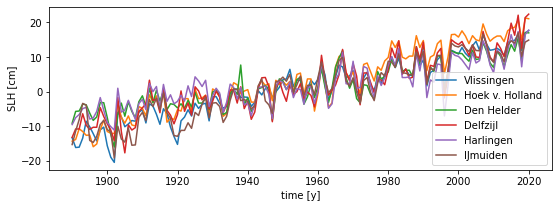

In [3]:
# Import tide gauge data
path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/tg_data.csv'
tg_data_df = pd.read_csv(path)
tg_data_df = tg_data_df.set_index('time').drop('Average', axis=1)
tg_data_df.plot(figsize=(9,3), ylabel = 'SLH [cm]', xlabel = 'time [y]')

#### Compute the nodal potential at tide gauge locations

In [4]:
def nodal_tides_potential(lat, time_years):
    """
    Function to obtain the nodal cycle
    
    """
    h2 = 0.6032
    k2 = 0.298

    #nodal cycle correction
    A = 0.44*(1+k2-h2)*20*(3*np.sin(lat*np.pi/180.)**2-1)/10  # mm to cm
    nodcyc = A*np.cos((2*np.pi*(time_years-1922.7))/18.61 + np.pi)
    
    return nodcyc.values

In [5]:
h2 = 0.6032
k2 = 0.298
0.44*(1+k2-h2)*20

6.114240000000001

In [23]:
nodal = pd.DataFrame({'time':tg_data_df.index.values})
nodal = nodal.set_index('time')

for station in tg_coords.index:

        #Remove nodal cycle
        nodal_cor = nodal_tides_potential(tg_coords['lat'][station], tg_data_df.index)
        
        # Add to nodal dataframe
        nodal[station] = nodal_cor
        
tg_wh_nodal = tg_data_df - nodal

In [24]:
nodal.max()

Vlissingen         0.510219
Hoek v. Holland    0.526888
Den Helder         0.557414
Delfzijl           0.568536
Harlingen          0.563906
IJmuiden           0.541915
dtype: float64

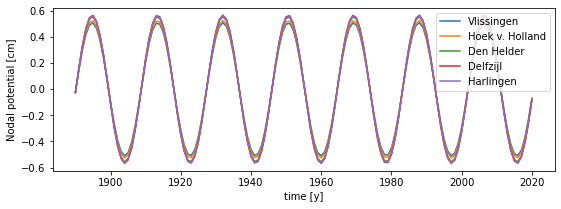

In [7]:
nodal.plot(figsize = (9,3), xlabel='time [y]', ylabel='Nodal potential [cm]')
plt.savefig(path_fig+'nodal_at_tg_stations')

In [8]:
# Obtain averages
tg_data_df['Average'] = tg_data_df.mean(axis=1)
tg_wh_nodal['Average'] = tg_wh_nodal.mean(axis=1)

In [19]:
tg_wh_nodal

,Delfzijl,Den Helder,Harlingen,Hoek v. Holland,IJmuiden,Vlissingen,Average
time,,,,,,,
1890,-13.170729,-9.082765,-9.492090,-14.301278,NaN,-13.324982,-11.874369
1891,-10.960301,-5.868629,-7.680118,-13.976964,NaN,-16.295109,-10.956224
1892,-11.131340,-5.936321,-6.949764,-11.035473,NaN,-16.348604,-10.280300
1893,-6.864532,-4.066908,-5.381872,-11.958908,NaN,-13.868134,-8.428071
1894,-10.244839,-4.345644,-5.061525,-13.133332,NaN,-9.040204,-8.365109
...,...,...,...,...,...,...,...
2016,16.870359,12.247738,13.344591,19.100172,NaN,15.360605,15.384693
2017,22.622499,16.100814,17.897121,21.255818,NaN,16.917654,18.958781
2018,12.816077,9.296475,7.591566,15.357192,NaN,12.322149,11.476692


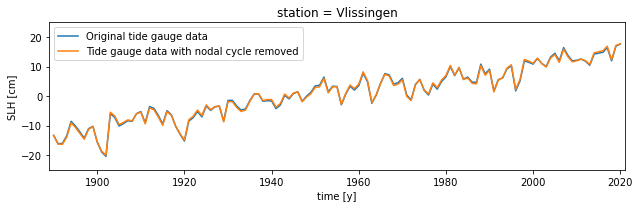

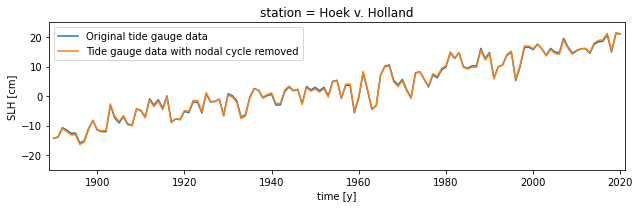

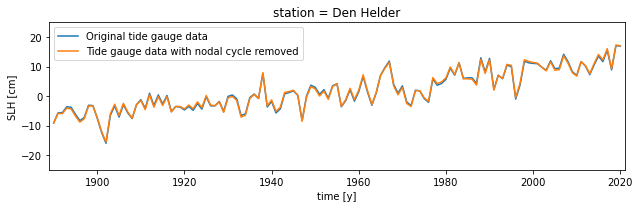

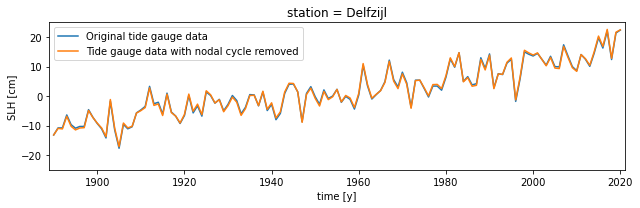

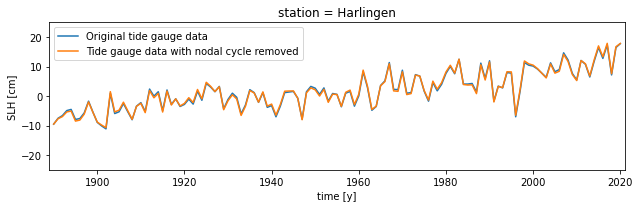

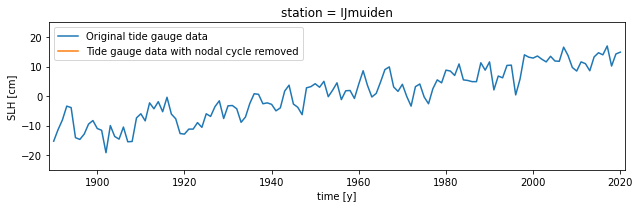

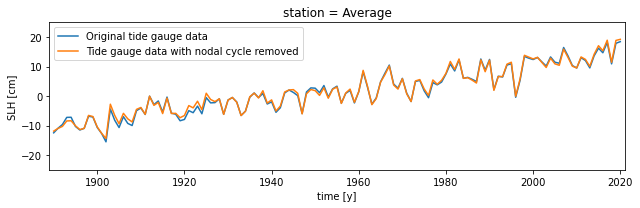

In [9]:
import matplotlib.pyplot as plt

for station in tg_data_df.columns:
    plt.figure(figsize=(9,3))
    plt.plot(tg_data_df.index, tg_data_df[station], label = 'Original tide gauge data')
    plt.plot(tg_wh_nodal.index, tg_wh_nodal[station], label = 'Tide gauge data with nodal cycle removed')
    plt.xlim(1889, 2021)
    plt.ylim(-25,25)
    plt.title(f'station = {station}')
    plt.xlabel('time [y]')
    plt.ylabel('SLH [cm]')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_fig+f'tg_wh_nodal_{station}.png')

### Also obtain IBE correction to make plot including both

In [10]:
# Import necessary functions
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


# Declare path
path = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Pressure/'
path_coords = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/Coordinates/'
path_fig = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Figures/Data examination/IBE/'

In [11]:
# Import data
pres_era5 = xr.open_dataset(path+'pres_annual_era5.nc')
pres_20cr = xr.open_dataset(path+'pres_annual_20cr.nc')

In [12]:
# Import tide gauge station coordinates
tg_coords = pd.read_csv(path_coords+'tgstations.csv', index_col='station')
tg_coords = tg_coords

#### Compute IBE at tide gauge locations

In [13]:
def ibe_df(pressure):
    
    # Declare variables
    rho = 1030 # Density of ocean water
    g = 9.81 # Acceleration of gravity on Earth's surface
    
    
    df = pd.DataFrame({'time':pressure.year.values})
    df = df.set_index('time')
    
    for station in tg_coords.index:
        pres = pressure.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method='Nearest').pressure.values
        pres = pres - pres.mean() # Calculate anomaly while i have no idea why
        
        ibe = -pres/(rho*g)*100 # Inverse barometer effect in cm
        df[station] = ibe - ibe.mean() # Calculate anomaly?? again and save in DataFrame
        
    df['Average'] = df.mean(axis=1)
    
    return df

In [14]:
ibe_20cr = ibe_df(pres_20cr)

In [15]:
def remove_ibe(tg_data, ibe):
    
    # Create dataframes of equal time span
    tg_data = tg_data[tg_data.index.isin(ibe.index)]
    ibe = ibe[ibe.index.isin(tg_data.index)]
    
    df = pd.DataFrame({'time':tg_data.index.values})
    df = df.set_index('time')
    
    
    for station in tg_data.columns:
        removed = tg_data[station].values - ibe[station].values
        df[station] = removed
        
    return df

In [16]:
tg_wh_ibe_20cr = remove_ibe(tg_data_df, ibe_20cr)

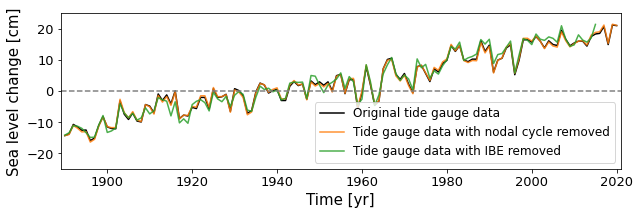

In [18]:
station = 'Hoek v. Holland'
fsize = 13
plt.figure(figsize=(9,3))
plt.plot(tg_data_df.index, tg_data_df[station], label = 'Original tide gauge data', color = 'k')
plt.plot(tg_wh_nodal.index, tg_wh_nodal[station], label = 'Tide gauge data with nodal cycle removed', alpha = 0.85, color = 'tab:orange')
plt.plot(tg_wh_ibe_20cr.index, tg_wh_ibe_20cr[station], label = 'Tide gauge data with IBE removed', alpha = 0.85, color = 'tab:green')
plt.xlim(1889, 2021)
plt.ylim(-25,25)
#plt.title(f'station = {station}')
plt.xlabel('Time [yr]', fontsize = 15)
plt.ylabel('Sea level change [cm]', fontsize = 15)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize)
plt.axhline(color='grey', linestyle='--')
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig(path_fig+f'tg_wh_nodal_and_ibe_{station}.png', bbox_inches = 'tight')